In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
tweet_fold = "/content/gdrive/MyDrive/LSDM/Proj_4/tweet_processed"

In [ ]:
!pip install transformers

In [6]:
# download packages

# import packages
import re
import torch
import random
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, TrainingArguments, Trainer, GPT2LMHeadModel
import re

## Define class and functions
#--------

# Dataset class
class TweetDataset(Dataset):
    def __init__(self, txt_list, tag_list, tokenizer, max_length):

        # Class vriables ot hold tokenised data and span
        self.input_ids = []
        self.attn_masks = []
        self.labels = []

        map_label = {'#gohawks':0, '#patriots':1, '#sb49':2, '#superbowl':3, '#nfl':4, '#gopatriots':5}

        old = ""
        # iterate through the dataset
        for txt, tag in zip(txt_list, tag_list):
            # prepare the text
            if old =="":
              old = tag

            txt_n = re.sub(r'http\S+', '', txt, flags=re.MULTILINE)
            prep_txt = f'<|startoftext|>Tag: {old}<|pad|>Text: {txt_n}<|endoftext|>'
            # tokenize
            encodings_dict = tokenizer(prep_txt, truncation=True,
                                       max_length=max_length, padding="max_length")
            # append to list
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
            # self.labels.append(txt)
            self.labels.append(torch.tensor(map_label[tag]))
            # print(encodings_dict)
            # raise TypeError
            old = tag

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx], self.labels[idx]

# Data load function
def load_tweet_dataset(tokenizer):

    file_path = tweet_fold + "/combined.txt"
    df = pd.read_csv(file_path, encoding='utf-8', header=None, sep='\t',lineterminator='\n')
    
    df.columns = ['tag', 'text']

    #vary sampling to increase train data size
    df = df.sample(10000, random_state=1)

    # divide into test and train
    X_train, X_test, y_train, y_test = \
              train_test_split(df['text'].tolist(), df['tag'].tolist(),
              shuffle=True, test_size=0.05, random_state=42, stratify=df['tag'])

    train_dataset = TweetDataset(X_train, y_train, tokenizer, max_length=512)

    test_dataset = TweetDataset(X_test, y_test, tokenizer, max_length=512)
    
    # return train_dataset, (X_test, y_test)

    return train_dataset, test_dataset, X_test, y_test


In [7]:
## Load model and data
#--------

# set model name
model_name = "gpt2"
# seed
torch.manual_seed(42)

# load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained(model_name, bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>', pad_token='<|pad|>')
model = GPT2LMHeadModel.from_pretrained(model_name).cuda()
model.resize_token_embeddings(len(tokenizer))

# prepare and load dataset
train_dataset, test_dataset, X_test, y_test = load_tweet_dataset(tokenizer)

## Train

# creating training arguments
training_args = TrainingArguments(output_dir='results', num_train_epochs=5, logging_steps=10,
                                 load_best_model_at_end=True, save_strategy="epoch", evaluation_strategy="epoch",
                                 per_device_train_batch_size=4, per_device_eval_batch_size=4,
                                 warmup_steps=100, weight_decay=0.01, logging_dir='logs')

# start training
trainer  = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset,
        data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                    'attention_mask': torch.stack([f[1] for f in data]),
                                    'labels': torch.stack([f[0] for f in data])})
trainer.train()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.140800,0.153866
2,0.108000,0.151664
3,0.129700,0.150932
4,0.110600,0.152635
5,0.118200,0.155354


TrainOutput(global_step=11875, training_loss=0.15248772227638646, metrics={'train_runtime': 7750.0926, 'train_samples_per_second': 6.129, 'train_steps_per_second': 1.532, 'total_flos': 1.241137152e+16, 'train_loss': 0.15248772227638646, 'epoch': 5.0})

In [8]:
metrics = trainer.state.log_history
metrics
t_loss = [k['loss'] for k in metrics if 'loss' in k]
t_epoch = [k['epoch'] for k in metrics if 'loss' in k]

e_loss = [k['eval_loss'] for k in metrics if 'eval_loss' in k]
e_epoch = [k['epoch'] for k in metrics if 'eval_loss' in k]

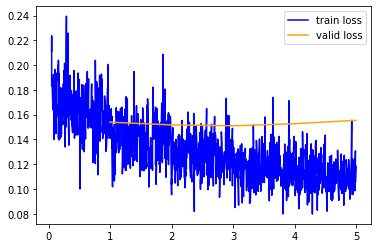

In [36]:
plt.plot(t_epoch[10:], t_loss[10:], color = 'blue', label = 'train loss')
plt.plot(e_epoch, e_loss, color = 'orange', label = 'valid loss')
plt.legend()
plt.show()

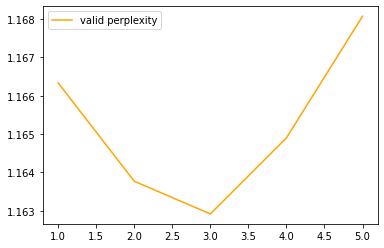

In [10]:
import numpy as np
ppl = np.exp(e_loss)
plt.plot(e_epoch, ppl, color = 'orange', label = 'valid perplexity')
plt.legend()
plt.show()

In [28]:
## Test
import random
# set the model to eval mode
_ = model.eval()

# run model inference on all test data
original_tag, original_text, predicted_text_list = [], [], []
# map_label = {0:'negative', 4: 'positive'}
map_label = {0:'#gohawks', 1:'#patriots', 2:'#sb49', 3:'#superbowl', 4:'#nfl', 5:'#gopatriots'}
# iter over all of the test data
old = ""
for text, tag in tqdm(zip(X_test, y_test)):
    # create prompt (in compliance with the one used during training)
    if old == "":
      old = tag
    prompt = f'<|startoftext|>Tag: {old}\nText:'
    # generate tokens
    generated = tokenizer(f"{prompt}", return_tensors="pt").input_ids.cuda()
    # perform prediction
    sample_outputs = model.generate(generated, do_sample=False, top_k=50, max_length=512, num_beams = 20, top_p=0.90, 
            temperature=0, num_return_sequences=20)
    # decode the predicted tokens into texts
    predicted_text  = tokenizer.decode(sample_outputs[random.randint(0,19)], skip_special_tokens=True)
    # extract the predicted sentiment
    try:
        pred_text = re.findall("\nText: (.*)", predicted_text)[-1]
        pred_text = re.sub(r'http\S+', '', pred_text, flags=re.MULTILINE)
    except:
        pred_text = "None"
    # append results
    original_tag.append(text)
    original_text.append(tag)
    predicted_text_list.append(pred_text)
    old = text

# transform result into dataframe
df = pd.DataFrame({'original_text': original_text,
                    'original_tag': original_tag, 
                   'predicted_text': predicted_text_list})


0it [00:00, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
1it [00:12, 12.98s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
2it [00:25, 12.54s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
3it [00:38, 12.71s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain re

In [9]:
df['predicted_text'].unique()

array(["I've got the @Patriots winning #SB49! #PatriotsWIN @NFL  #PatriotsWIN @NFL ",
       "I've got the @Patriots winning #SB49! #PatriotsWIN @NFL ",
       "I've got the @Seahawks winning #SB49! #GoHawks! #SeahawksWIN @NFL ",
       "I've got the @patriots winning #SB49! #PatriotsWIN @NFL ",
       "I've got the @Patriots winning #SB49! Brady winning #PatriotsWIN @NFL ",
       "I've got the @Seahawks winning #SB49! #SeahawksWIN @NFL  ",
       'None',
       "I've got the @Patriots winning #SB49! 💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙�💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙",
       '#PatriotsWIN @NFL ',
       "I've got the @Patriots winning @NFL! #PatriotsWIN @NFL ",
       "I've got the @Seahawks winning #SB49! #GoSeahawks! #SeahawksWIN @NFL ",
       "I've got the @Seahawks winning #SB49! #SeahawksWIN @NFL ",
       "I've got the @Seahawks winning #Patriots winning #SB49! #SeahawksWIN @NFL ",
   

#Model Sample Outputs

"I've got the @Seahawks winning #SB49! #SeahawksWIN @NFLPlayoffs"

"I've got the @Patriots winning #SB49! #PatriotsWIN @NBC"

I voted for #LIKEAGIRL from @Always to be this year's #TopSpot2015 #SB49 ,

I've got the @Patriots winning #SB49! 💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙�💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙💙"

"What's better than a good #SuperBowl game?"

'#Seahawks #Patriots #SuperBowlXLIX',

"I've got the @Patriots winning #SB49! Brady winning #PatriotsWIN @NFL "

'Katy Perry needs to give Nintendo credit. #SuperBowl',

'#GoPats'

🙂🙂🙂🙂

'#Halftime'

'#GoHawks #12s #12s'

'#GoHawks #SuperBowlXLIX', '#SuperBowlXLIX'

'TOUCHDOWN AMENDOLA! #SB49 #FinishTheJob'

'Are companies saying we need to be better dads?   #SuperBowl'

'Jurassic World #SuperBowl'

'#KatyPerry #SuperBowl', "I'm just here so I don't get fined."

'#AllYouNeedisEcuador #SB49'

'#Patriots Injury Update: Julian Edelman has a hip injury &amp; his return is questionable. #NFL'

'#DeflateGate #SuperBowlXLIX'

'I hope the #Patriots look like this in two weeks',

"I've got the @Colts winning #SB49! #ColtsWIN @NFL "

"I've got the @DangeRussWilson winning #SB49! #DangeRussWilsonWIN @NFL ",

Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy Perry Katy'

'Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown! Touchdown. Touchdown',

HalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHalftimeshowHal',
 

#Finetuning GPT-2 on Twitter data

We attempted to finetune the GPT-2 model on the extracted twitter data. To do so we followed the following steps:

#Data preprocessing

As the input data is present in a json format, we first extract all the relevant fields from the provided data files. We then extract only the tweet hastags and text from each individual file, and concatenate them to a single file. In addiiton to just keeping the relevant data required for training the mode, this also reduces the size of the input data files and thus makes it possible to fit the data files on the vram required to train the model on the GPU available on Google Colab. 

For the tweet texts themselves, we did minimal data cleaning, focusing primarily on the removal of any urls present in the data. This is done as the urls primarily are links to pictures uploaded by users on twitter, which maybe invalid, as well as the fact the 'random' string of characters present in shortened urls leads to cycling of data in the output tweets, and a lack of prediction of a end of sentence token. We also encode the tweets at utf-8 characters to ensure the proper rendering of emojis and other non-english charcaters


#Tokenization and Prompt Generation

To tokenize the input tweets, we use the available gpt2 tokenizer from hugging faces to encode the text data. To generate prompts to feed into the pretrained gpt model, we use the following format:

'<|startoftext|>Tag: {}\nText:{}'

We initially use 'Tag" to refer to hashtag which is used to label a sequence of tweets. We then sequentially feed the tweets in the text tag to simulate a twitter thread. An example of this is present below:

If the initial tag in a sequence of tags is #superbowl, followed by tweets t_1, ... ,t_n, the prompts would be the following:

'<|startoftext|>Tag: #superbowl \nText:t_1'

'<|startoftext|>Tag: t_1 \nText:t_2'

and so on, till a new tag is encountered, when the process is repeated.


#Model training 

The model is trained by creating a custom dataloader class to feed in the tweets to a Trainer object from huggingfaces. The dataloader creates tokenized versions of the prompts, as well labels and an attention_mask for training the model. To train the model we use the neg log likelihood loss as in the original gpt-2 paper. We also report the ppl (perplexity) loss from the model on the validation sets.

Due to the large size of the input dataset, as well as the computation constraints involved with training a large language model on google colab, we elect to use just a subset of the dataset for training. We experiment with using 1k, 5k, 10k and 15k samples for the training, and we report training curves and inference outputs from the 10k iterations for 10 epochs.

#Model Inference

To perform inference on the model, we present prompts in a similar format to training. However we also perform a beam search across the output logits, with a beam width of 20. This allows us to search for outputs other than the most commonly predicted entries. This both helps prevent any cycles present in the most likely predicted text, as well as counteract the presence of any repeated tweets in the input dataset (an issue that can occur due to the small training set size as well as tweets that might be similar to a premade template due to the removal of the urls)

#Observed results

We present the observed results after finetuning the data on gpt-2. We observe that the output tends to settle into a few patterns, notably of the type "I've got the ____ winning #SB49! ______ @NFLPlayoffs" 

We also interestingly notice the tweet I voted for #LIKEAGIRL from @Always to be this year's #TopSpot2015 #SB49  is also repeated quite often

We also see that the model tends to reproduce tweets present in the input dataset word by word occasionally. This is how the model is able tweet about the injury update on Edelman, or the touchdown scored by Amandola 

We also see that the model tends to recognize Colts, Pats and Hawks as NFL tema sof some kind, and is thus able to substite Colts for Pats and able to hallucinate the presence of a tweet impying the colts could win the superbowl, even though they were not present in the game

We also ocassionally notice that the model picks up on trends present in the Halftime show, and is thus able to make a few tweets on Katy Perry and Nintendo

We also observe that when attempting to pick up emojis, the model notes that emojis tend to be repeated by users for emphasis. However, the model is unable to predict when to terminate prodicing emojis, and thus tends to keeps predicting them multiple times

Finally we also notice that ocassionally the model fails to predict an end of sentence token, leading to cycled of the same tags. This leads to the repeated 'Katy Perry', 'Touchdown' and 'Halftime Show' outputs